In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

# Lecture 1: Constructing LSTM Model

In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/BCA_Team/Data Repo/tabular_data/D202.csv')

In [ ]:
print(data)

                 TYPE        DATE START TIME END TIME  USAGE UNITS    COST  \
0      Electric usage  10/22/2016       0:00     0:14   0.01   kWh  $0.00    
1      Electric usage  10/22/2016       0:15     0:29   0.01   kWh  $0.00    
2      Electric usage  10/22/2016       0:30     0:44   0.01   kWh  $0.00    
3      Electric usage  10/22/2016       0:45     0:59   0.01   kWh  $0.00    
4      Electric usage  10/22/2016       1:00     1:14   0.01   kWh  $0.00    
...               ...         ...        ...      ...    ...   ...     ...   
70363  Electric usage  10/24/2018      22:45    22:59   0.02   kWh  $0.00    
70364  Electric usage  10/24/2018      23:00    23:14   0.03   kWh  $0.01    
70365  Electric usage  10/24/2018      23:15    23:29   0.03   kWh  $0.01    
70366  Electric usage  10/24/2018      23:30    23:44   0.03   kWh  $0.01    
70367  Electric usage  10/24/2018      23:45    23:59   0.03   kWh  $0.01    

       NOTES  
0        NaN  
1        NaN  
2        NaN  
3  

In [ ]:
data = data.drop(columns=['TYPE', 'NOTES'])

In [ ]:
print(data['UNITS'].unique())

['kWh']


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        70368 non-null  object 
 1   START TIME  70368 non-null  object 
 2   END TIME    70368 non-null  object 
 3   USAGE       70368 non-null  float64
 4   UNITS       70368 non-null  object 
 5   COST        70368 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.2+ MB


In [ ]:
window_size = 20
input_cols = ['USAGE', 'COST']
num_input_cols = len(input_cols)
windows_X = np.zeros(((len(data)-window_size), window_size, num_input_cols))
# New Code Here
windows_y = np.zeros(((len(data)-window_size), 1, num_input_cols)) # 1 b/c just one element
# Because num_input_cols = 2, that means we're predicting 2 columns

# End New Code

In [ ]:
data['COST'] = data['COST'].str.replace('$', '')
data['COST'] = pd.to_numeric(data['COST'])

In [ ]:
for i in range(len(data)-window_size):
  windows_X[i, :, :] = data[input_cols].iloc[i:i+window_size] # Slicing takes 20 elements, excluding b in a:b
  # New Code Here
  windows_y[i, :, :] = data[input_cols].iloc[i+window_size] # Takes a single element (b), which comes right after windows_X
  # End New Code

In [ ]:
# New Code Here
windows_X_train = windows_X[:int(np.floor(len(windows_X)*0.8))]
windows_y_train = windows_y[:int(np.floor(len(windows_X)*0.8))]
# Takes first 80% of the data
# floor rounds down so you don't accidentally round up over your index
# needs it to be integer b/c float doesn't work

windows_X_validation = windows_X[int(np.floor(len(windows_X)*0.8)):int(np.floor(len(windows_X)*0.9))]
windows_y_validation = windows_y[int(np.floor(len(windows_y)*0.8)):int(np.floor(len(windows_y)*0.9))]

windows_X_test = windows_X[int(np.floor(len(windows_X)*0.9)):] # : with nothing after = go till the end
windows_y_test = windows_y[int(np.floor(len(windows_y)*0.9)):]
# End New Code

In [ ]:
prediction = tf.keras.layers.Dense(num_input_cols)
inputs = tf.keras.Input(shape=(window_size, num_input_cols,)) # Our windows are 2D (# time steps, and # input cols)
x = tf.keras.layers.LSTM(units=64, activation='tanh', return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(units=64, activation='tanh', return_sequences=True)(x)
# return_sequences = True means we need an input that is multidimensional, cannot be flat like Dense layer
# if False, then it passes it out like a flattened layer similar to a Dense layer
# But we want to make sure multidimensional inputs continue when we input into an LSTM layer
# We make it False b/c we are inputting into a Dense layer
x = tf.keras.layers.LSTM(units=64, activation='tanh', return_sequences=False)(x) # False for last LSTM layer
outputs = prediction(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001

model_optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model_loss=tf.keras.losses.MeanSquaredError()

model.compile(optimizer=model_optimizer, loss=model_loss)

model_epochs = 10

model_early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                       restore_best_weights=True,
                                                       monitor='val_loss')

In [ ]:
model.fit(windows_X_train, windows_y_train,
          validation_data=(windows_X_validation, windows_y_validation),
          epochs=model_epochs, callbacks=[model_early_stopping])

Epoch 1/10
1759/1759 [==============================] - 78s 44ms/step - loss: 0.0274 - val_loss: 0.0081
Epoch 2/10
1759/1759 [==============================] - 77s 44ms/step - loss: 0.0273 - val_loss: 0.0077
Epoch 3/10
1759/1759 [==============================] - 72s 41ms/step - loss: 0.0273 - val_loss: 0.0077
Epoch 4/10
1759/1759 [==============================] - 74s 42ms/step - loss: 0.0273 - val_loss: 0.0079
Epoch 5/10
1759/1759 [==============================] - 71s 40ms/step - loss: 0.0273 - val_loss: 0.0077
Epoch 6/10
1759/1759 [==============================] - 68s 39ms/step - loss: 0.0273 - val_loss: 0.0078
Epoch 7/10
1759/1759 [==============================] - 72s 41ms/step - loss: 0.0273 - val_loss: 0.0078
Epoch 8/10
1759/1759 [==============================] - 68s 38ms/step - loss: 0.0273 - val_loss: 0.0080


# Lecture 2: Let's Make Improvements (A Review)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/coreyjwade/odsc/main/bike_rentals.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    float64
 3   yr          730 non-null    float64
 4   mnth        730 non-null    float64
 5   holiday     731 non-null    float64
 6   weekday     731 non-null    float64
 7   workingday  731 non-null    float64
 8   weathersit  731 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         728 non-null    float64
 12  windspeed   726 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(10), int64(5), object(1)
memory usage: 91.5+ KB


In [ ]:
data = data.drop(columns=['dteday'])
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     721 non-null    int64  
 1   season      721 non-null    float64
 2   yr          721 non-null    float64
 3   mnth        721 non-null    float64
 4   holiday     721 non-null    float64
 5   weekday     721 non-null    float64
 6   workingday  721 non-null    float64
 7   weathersit  721 non-null    int64  
 8   temp        721 non-null    float64
 9   atemp       721 non-null    float64
 10  hum         721 non-null    float64
 11  windspeed   721 non-null    float64
 12  casual      721 non-null    int64  
 13  registered  721 non-null    int64  
 14  cnt         721 non-null    int64  
dtypes: float64(10), int64(5)
memory usage: 90.1 KB


In [ ]:
data.head(25)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,6,1.0,0.0,1.0,0.0,4.0,1.0,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,7,1.0,0.0,1.0,0.0,5.0,1.0,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,8,1.0,0.0,1.0,0.0,6.0,0.0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,9,1.0,0.0,1.0,0.0,0.0,0.0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,10,1.0,0.0,1.0,0.0,1.0,1.0,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321


In [ ]:
data = pd.get_dummies(data, columns=['season', 'mnth', 'weekday', 'weathersit'], dtype=int)
print(data.head(25))

    instant   yr  holiday  workingday      temp     atemp       hum  \
0         1  0.0      0.0         0.0  0.344167  0.363625  0.805833   
1         2  0.0      0.0         0.0  0.363478  0.353739  0.696087   
2         3  0.0      0.0         1.0  0.196364  0.189405  0.437273   
3         4  0.0      0.0         1.0  0.200000  0.212122  0.590435   
4         5  0.0      0.0         1.0  0.226957  0.229270  0.436957   
5         6  0.0      0.0         1.0  0.204348  0.233209  0.518261   
6         7  0.0      0.0         1.0  0.196522  0.208839  0.498696   
7         8  0.0      0.0         0.0  0.165000  0.162254  0.535833   
8         9  0.0      0.0         0.0  0.138333  0.116175  0.434167   
9        10  0.0      0.0         1.0  0.150833  0.150888  0.482917   
10       11  0.0      0.0         1.0  0.169091  0.191464  0.686364   
11       12  0.0      0.0         1.0  0.172727  0.160473  0.599545   
12       13  0.0      0.0         1.0  0.165000  0.150883  0.470417   
13    

In [ ]:
data_1 = pd.read_csv('/content/drive/Shareddrives/BCA_Team/Data Repo/tabular_data/D202.csv')

In [ ]:
data_1['COST'] = data_1['COST'].str.replace('$', '')
data_1['COST'] = pd.to_numeric(data_1['COST'])
data_1['START TIME'] = data_1['START TIME'].str.replace(":", '')
data_1['START TIME'] = pd.to_numeric(data_1['START TIME'])

In [ ]:
window_size = 20
input_cols = ['USAGE', 'COST', 'START TIME']
num_input_cols = len(input_cols)
windows_X = np.zeros(((len(data_1)-window_size), window_size, num_input_cols))
# New Code Here
windows_y = np.zeros(((len(data_1)-window_size), 1, num_input_cols)) # 1 b/c just one element
# Because num_input_cols = 2, that means we're predicting 2 columns

# End New Code

In [ ]:
for i in range(len(data_1)-window_size):
  windows_X[i, :, :] = data_1[input_cols].iloc[i:i+window_size] # Slicing takes 20 elements, excluding b in a:b
  # New Code Here
  windows_y[i, :, :] = data_1[input_cols].iloc[i+window_size] # Takes a single element (b), which comes right after windows_X
  # End New Code

In [ ]:
# New Code Here
windows_X_train = windows_X[:int(np.floor(len(windows_X)*0.8))]
windows_y_train = windows_y[:int(np.floor(len(windows_X)*0.8))]
# Takes first 80% of the data
# floor rounds down so you don't accidentally round up over your index
# needs it to be integer b/c float doesn't work

windows_X_validation = windows_X[int(np.floor(len(windows_X)*0.8)):int(np.floor(len(windows_X)*0.9))]
windows_y_validation = windows_y[int(np.floor(len(windows_y)*0.8)):int(np.floor(len(windows_y)*0.9))]

windows_X_test = windows_X[int(np.floor(len(windows_X)*0.9)):] # : with nothing after = go till the end
windows_y_test = windows_y[int(np.floor(len(windows_y)*0.9)):]
# End New Code

In [ ]:
prediction = tf.keras.layers.Dense(num_input_cols)
inputs = tf.keras.Input(shape=(window_size, num_input_cols,)) # Our windows are 2D (# time steps, and # input cols)
x = tf.keras.layers.LSTM(units=64, activation='tanh', return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(units=64, activation='tanh', return_sequences=True)(x)
# return_sequences = True means we need an input that is multidimensional, cannot be flat like Dense layer
# if False, then it passes it out like a flattened layer similar to a Dense layer
# But we want to make sure multidimensional inputs continue when we input into an LSTM layer
# We make it False b/c we are inputting into a Dense layer
x = tf.keras.layers.LSTM(units=64, activation='tanh', return_sequences=False)(x) # False for last LSTM layer
x = tf.keras.layers.Dense(units=256, activation='tanh')(x)
x = tf.keras.layers.Dense(units=256, activation='tanh')(x)
x = tf.keras.layers.Dense(units=256, activation='tanh')(x)
outputs = prediction(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

model_optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model_loss=tf.keras.losses.MeanSquaredError()

model.compile(optimizer=model_optimizer, loss=model_loss)

model_epochs = 20

model_early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                       restore_best_weights=True,
                                                       monitor='val_loss')

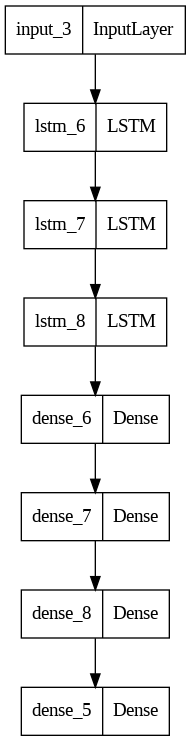

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(windows_X_train, windows_y_train,
          validation_data=(windows_X_validation, windows_y_validation),
          epochs=model_epochs, callbacks=[model_early_stopping])